This demo provides an example about how to compute the metrics of PU, UIoU and ECE in the paper "Evidential fully convolutional network for semantic segmentation". Please note that, before execute the demo, users should make sure that they can execute the code in the file 'E-Unet.ipynb' to train a E-FCN.

Let's begin with some preparations.

In [1]:
##############################
# This cell is the same as the file 'E-Unet.ipynb' to import the libraries.
##############################
import tensorflow as tf
print(tf.__version__)
import tensorflow_datasets as tfds
#import keras
from tensorflow import keras
from keras.utils import np_utils
from keras.callbacks import ModelCheckpoint

import sys
print("python版本:%s"% sys.version)
from google.colab import drive
drive.mount('/content/gdrive')
sys.path.append('/content/gdrive/My Drive/fcn_custom/libs')
import ds_layer_p2p #Dempster-Shafer layer for p2p classification
import pt_layer_p2p #pignisitic transform layer
import utility_layer_p2p #Utility layer for imprecision segmenatation

import numpy as np
from tqdm import tqdm 
from skimage.io import imread, imshow
from skimage.transform import resize
import matplotlib.pyplot as plt
import matplotlib as mpl 
from scipy.optimize import minimize
import math

2.7.0
python版本:3.7.12 (default, Sep 10 2021, 00:21:48) 
[GCC 7.5.0]
Mounted at /content/gdrive


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incompleteQW249O/oxford_iiit_pet-train.tfrecord


  0%|          | 0/3680 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incompleteQW249O/oxford_iiit_pet-test.tfrecord


  0%|          | 0/3669 [00:00<?, ? examples/s]

Dataset oxford_iiit_pet downloaded and prepared to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0. Subsequent calls will reuse this data.


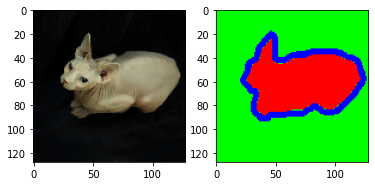

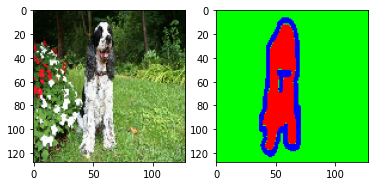

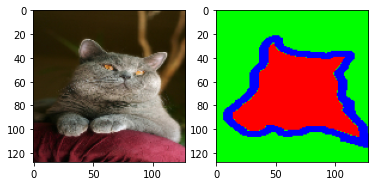

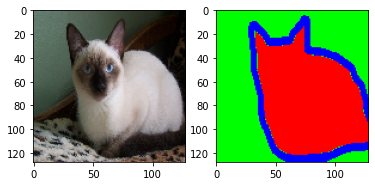

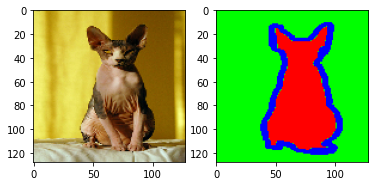

In [2]:
##############################
# This cell is the same as the file 'E-Unet.ipynb' to prepare the dataset
# Please note that in the dataset, we consider the boundary labels as soft labels
#############################
data_train = tfds.load('oxford_iiit_pet:3.*.*', split="train")

train_x = []
train_y_label = []
for dataset in data_train:
  train_x.append(tf.image.resize(dataset["image"]/255, (128, 128)))
  train_y_label.append(tf.image.resize(dataset["segmentation_mask"]-1, (128, 128)))

train_x = np.array(train_x)
train_y_label = np.array(train_y_label)
train_y = np_utils.to_categorical(train_y_label)

# let's see some examples
colors = ['red', 'green', 'blue']
cmap = mpl.colors.ListedColormap(colors)
for i in range(5):
    plt.subplot(121)
    plt.imshow(np.squeeze(train_x[i]))
    plt.subplot(122)
    plt.imshow(np.squeeze(train_y[i]), cmap=cmap)
    plt.show()
plt.show()

In [3]:
##############################
# This cell is generate utility matrixs with/without soft labels
# Users should carefully select the matrixs based on their datasets with/without soft labels
#############################

#Frist generate a utility matrix
num_class = 2
# aim func: cross entropy
def func(x):
  fun=0
  for i in range(len(x)):
    fun += x[i] * math.log10(x[i])
  return fun

#constraint 1: the sum of weights is 1
def cons1(x):
  return sum(x)

#constraint 2: define tolerance to imprecision
def cons2(x):
  tol = 0
  for i in range(len(x)):
    tol += (len(x) -(i+1)) * x[i] / (len(x) - 1)
  return tol

#compute the weights g for ordered weighted average aggreagtion

for j in range(2,(num_class+1)):
  num_weights = j
  ini_weights = np.asarray(np.random.rand(num_weights))

  name='weight'+str(j)
  locals()['weight'+str(j)]= np.zeros([5, j])

  for i in range(5):
    tol = 0.5 + i * 0.1

    cons = ({'type': 'eq', 'fun' : lambda x: cons1(x)-1},
          {'type': 'eq', 'fun' : lambda x: cons2(x)-tol},
          {'type': 'ineq', 'fun' : lambda x: x-0.00000001}
        )
  
    res = minimize(func, ini_weights, method='SLSQP', options={'disp': True}, constraints=cons)
    locals()['weight'+str(j)][i] = res.x
    print (res.x)

#function for power set
def PowerSetsBinary(items):  
    #generate all combination of N items  
    N = len(items)  
    #enumerate the 2**N possible combinations  
    set_all=[]
    for i in range(2**N):
        combo = []  
        for j in range(N):  
            if(i >> j ) % 2 == 1:  
                combo.append(items[j]) 
        set_all.append(combo)
    return set_all

class_set=list(range(num_class))
act_set= PowerSetsBinary(class_set)
act_set.remove(act_set[0])#emptyset is not needed
act_set=sorted(act_set, key=len)
number_act_set = len(act_set)
print(act_set)
print(len(act_set))

utility_matrix = np.zeros([len(act_set), len(class_set)])
tol_i = 3 
#tol_i = 0 with tol=0.5, tol_i = 1 with tol=0.6, tol_i = 2 with tol=0.7, tol_i = 3 with tol=0.8, tol_i = 4 with tol=0.9
for i in range(len(act_set)):
  intersec = class_set and act_set[i]
  if len(intersec) == 1:
    utility_matrix[i, intersec] = 1
  
  else:
    for j in range(len(intersec)):
      utility_matrix[i, intersec[j]] = locals()['weight'+str(len(intersec))][tol_i, 0]
print (utility_matrix)

soft_part = np.zeros([len(act_set), (len(act_set)-num_class)])
for i in range(len(act_set)):
  for j in range(len(act_set)-num_class):
    soft_label = act_set[j+num_class]
    utility = 0
    for k in range(len(soft_label)):
      utility += utility_matrix[i, soft_label[k]]
    utility = utility/len(soft_label)
    soft_part[i,j] = utility

for i in range(len(act_set)-num_class):
  soft_part[:,i] = soft_part[:,i]/soft_part[(i+num_class),i]

utility_matrix_soft = np.concatenate((utility_matrix, soft_part), axis=1)
print (utility_matrix_soft)


Optimization terminated successfully.    (Exit mode 0)
            Current function value: -0.3010299956639812
            Iterations: 2
            Function evaluations: 8
            Gradient evaluations: 2
[0.5 0.5]
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -0.29228525323862886
            Iterations: 2
            Function evaluations: 8
            Gradient evaluations: 2
[0.6 0.4]
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -0.2652949955741215
            Iterations: 2
            Function evaluations: 8
            Gradient evaluations: 2
[0.7 0.3]
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -0.21732201127364886
            Iterations: 2
            Function evaluations: 8
            Gradient evaluations: 2
[0.8 0.2]
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -0.14118174150460758
          

In [4]:
##############################
# This cell is to build an E-FCN and load its weights
#############################

IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 3
inputs_pixels = IMG_WIDTH * IMG_HEIGHT
prototypes=15
num_class=2

inputs = tf.keras.layers.Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))

#Contraction path
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(inputs)
c1 = tf.keras.layers.Dropout(0.1)(c1)
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1)

c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
c2 = tf.keras.layers.Dropout(0.1)(c2)
c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)
 
c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
c3 = tf.keras.layers.Dropout(0.2)(c3)
c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
p3 = tf.keras.layers.MaxPooling2D((2, 2))(c3)
 
c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
c4 = tf.keras.layers.Dropout(0.2)(c4)
c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
p4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(c4)
 
c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
c5 = tf.keras.layers.Dropout(0.3)(c5)
c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

#Expansive path 
u6 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
u6 = tf.keras.layers.concatenate([u6, c4])
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
c6 = tf.keras.layers.Dropout(0.2)(c6)
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
 
u7 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
u7 = tf.keras.layers.concatenate([u7, c3])
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
c7 = tf.keras.layers.Dropout(0.2)(c7)
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
 
u8 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
u8 = tf.keras.layers.concatenate([u8, c2])
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
c8 = tf.keras.layers.Dropout(0.1)(c8)
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
 
u9 = tf.keras.layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
u9 = tf.keras.layers.concatenate([u9, c1], axis=3)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
c9 = tf.keras.layers.Dropout(0.1)(c9)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)
feature_maps = tf.keras.layers.Conv2D(16, (1, 1), activation='relu')(c9)

ED=ds_layer_p2p.DS1(prototypes, 16)(feature_maps)
ED_ac=ds_layer_p2p.DS1_activate(prototypes)(ED)
mass_prototypes=ds_layer_p2p.DS2(prototypes, num_class)(ED_ac)
mass_prototypes_omega=ds_layer_p2p.DS2_omega(prototypes, num_class)(mass_prototypes)
mass_Dempster=ds_layer_p2p.DS3_Dempster(prototypes, num_class)(mass_prototypes_omega)
mass_Dempster_normalize=ds_layer_p2p.DS3_normalize()(mass_Dempster)

#add a utility layer at the outputs of a DS layer
outputs = utility_layer_p2p.DM_test(num_class, number_act_set, 0.9)(mass_Dempster_normalize)#nu = 0.9


model_sl_imprecise = tf.keras.Model(inputs=[inputs], outputs=[outputs])
model_sl_imprecise.compile(optimizer=keras.optimizers.Nadam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, schedule_decay=0.004), 
              loss='CategoricalCrossentropy',
              metrics=['accuracy'])
model_sl_imprecise.summary()

#get weights from the the E-FCN with soft labels mentioned above
#users can further fine-tune the model after they convert the mask label data 'train_y' into the utililty form.
model_sl_imprecise.layers[-1].set_weights(tf.reshape(utility_matrix, [1, number_act_set, num_class]))
model_sl_imprecise.load_weights('/content/gdrive/My Drive/fcn_custom/weights_zoo/pre_train/eUNET_yes_softlabel_checkpoint')

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/nadam.py:73: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Nadam, self).__init__(name, **kwargs)


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 16  448         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 dropout (Dropout)              (None, 128, 128, 16  0           ['conv2d[0][0]']                 
                                )                                                             

In [5]:
##############################
# This cell is to get the mass-fucntion outputs from the E-FCN
#############################
model_sl_imprecise_mass = tf.keras.Model(inputs=[inputs], outputs=[mass_Dempster_normalize])
model_sl_imprecise_mass.compile(optimizer=keras.optimizers.Nadam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, schedule_decay=0.004), 
              loss='CategoricalCrossentropy',
              metrics=['accuracy'])
model_sl_imprecise_mass.summary()

model_sl_imprecise_mass.load_weights('/content/gdrive/My Drive/fcn_custom/weights_zoo/pre_train/eUNET_yes_softlabel_checkpoint')

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/nadam.py:73: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Nadam, self).__init__(name, **kwargs)


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 16  448         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 dropout (Dropout)              (None, 128, 128, 16  0           ['conv2d[0][0]']                 
                                )                                                           

In [6]:
##############################
# This cell is to get the mass-fucntion outputs and predictions from the E-FCN
#############################
mass_output = model_sl_imprecise_mass.predict(train_x)
mask_label_train_yes_soft = tf.argmax(model_sl_imprecise.predict(train_x), -1)

Let's begin to compute the three matrics

First we should convert the masses into Pignistic probabilites of all acts.

In [7]:
##############################
# This cell is to compute PU
#############################

AU = tf.gather_nd(utility_matrix_soft, tf.concat([tf.expand_dims(mask_label_train_yes_soft, -1), train_y_label], -1))
print (f'The value of PU is {np.sum(AU)/(len(train_x)*IMG_WIDTH*IMG_HEIGHT)}.')

The value of PU is 0.9378636861884073.


In [8]:
#############################
# This cell is compute to UIoU
#############################

for i in range(len(act_set)):
  locals()['Pr_'+str(i)] = tf.equal(mask_label_train_yes_soft, i)

for i in range(np.size(utility_matrix_soft,1)):
  locals()['GT_'+str(i)] = tf.reshape(tf.equal(tf.cast(train_y_label, tf.int32), i), [len(train_x),IMG_WIDTH,IMG_HEIGHT])

for i in range(np.size(utility_matrix_soft,1)):
  for j in range(len(act_set)):
    locals()['results_'+str(j)+str(i)]= tf.logical_and(locals()['GT_'+str(i)], locals()['Pr_'+str(j)])

uiou = 0
for i in range(np.size(utility_matrix_soft,1)):
  intersec_score = 0
  union = 0
  for j in range(len(act_set)):
    intersec_score += np.sum(locals()['results_'+str(j)+str(i)]) * utility_matrix_soft[j,i]
  union = np.sum(tf.logical_or(locals()['GT_'+str(i)], locals()['Pr_'+str(i)]))
  print(f'The value of UIoU in soft label {i} is {intersec_score/union}.')
  uiou += intersec_score/union  

print (f'The value of UIoU is {uiou/(np.size(utility_matrix_soft,1))}.')

The value of UIoU in soft label 0 is 0.8732142471096062.
The value of UIoU in soft label 1 is 0.8720185699829966.
The value of UIoU in soft label 2 is 0.4203183024572074.
The value of UIoU is 0.72185037318327.


In [9]:
##############################
# This cell is to compute ECE
#############################
num_bin = 10 #Please define your number of bins

for i in range(num_class):
  locals()['BetP_'+str(i)] = mass_output[:,:,:,i] + mass_output[:,:,:,-1]/num_class

for i in range(np.size(soft_part, 1)):
  act = act_set[i+num_class]
  locals()['BetP_'+str(i+num_class)] = tf.zeros([len(train_x),IMG_WIDTH,IMG_HEIGHT])
  for j in range(len(act)):
    locals()['BetP_'+str(i+num_class)] += locals()['BetP_'+str(act[j])]

BetP = tf.expand_dims(locals()['BetP_'+str(0)], -1)
for i in range(np.size(utility_matrix_soft, 1)-1):
  BetP= tf.concat([BetP, tf.expand_dims(locals()['BetP_'+str(i+1)], -1)], -1)

confidence = tf.reduce_sum(tf.multiply(BetP, train_y), -1)

ECE = 0
for i in range(num_bin):
  index_bin_less = tf.math.less(confidence, (i+1)/num_bin+0.00001)
  index_bin = tf.logical_and(index_bin_less, tf.math.greater_equal(confidence, i/num_bin))
  co_bin = tf.boolean_mask(confidence, index_bin)
  au_bin = tf.boolean_mask(AU, index_bin)
  ece_bin = (np.sum(co_bin) - np.sum(au_bin))/np.sum(index_bin)
  ece_bin = ece_bin * np.sum(index_bin) / (len(train_x)*IMG_WIDTH*IMG_HEIGHT)
  ECE += abs(ece_bin)
  print (f'In the {i}-th bin, co({i})={np.sum(co_bin)/np.sum(index_bin)}, au({i})={np.sum(au_bin)/np.sum(index_bin)}, and ECE({i})={ece_bin}.')
print (f'ECE with {num_bin} bins are {ECE*100}%')

In the 0-th bin, co(0)=0.06944324689923938, au(0)=0.0, and ECE(0)=0.0005053039154280786.
In the 1-th bin, co(1)=0.1472840225328459, au(1)=0.0, and ECE(1)=0.0013163759656574414.
In the 2-th bin, co(2)=0.25071592732663384, au(2)=0.5001227041889682, and ECE(2)=-0.0021137257762577203.
In the 3-th bin, co(3)=0.3513766297004986, au(3)=0.799999999999999, and ECE(3)=-0.004339687513268503.
In the 4-th bin, co(4)=0.4518694078222704, au(4)=0.7999999999999988, and ECE(4)=-0.004088732055995761.
In the 5-th bin, co(5)=0.5521005209299124, au(5)=0.7999999999999985, and ECE(5)=-0.0037028854826222073.
In the 6-th bin, co(6)=0.6527648412530541, au(6)=0.7999999999999982, and ECE(6)=-0.0029324434114538734.
In the 7-th bin, co(7)=0.7545617782743791, au(7)=0.8725838598411491, and ECE(7)=-0.0036053752899169915.
In the 8-th bin, co(8)=0.8635994830157362, au(8)=1.0, and ECE(8)=-0.011356428395146908.
In the 9-th bin, co(9)=0.9367058933198952, au(9)=0.9670389995303413, and ECE(9)=-0.024426358679066534.
ECE with 1